# Convolution Neural Network and Computer Vision

Computer vision is the art of teaching a computer to see.

For example, it could involve building a model to classify whether a photo is of a cat or a dog (binary classification).

Or whether a photo is of a cat, dog or chicken (multi-class classification).

Or identifying where a car appears in a video frame (object detection).

Or figuring out where different objects in an image can be separated (image segmentation).

Convolution Neural Network (CNN) is a powerful model designed to solve computer vision problems. Here we will first import toolboxes that we need for our CNN.

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Load FashionMNIST dataset

Here we use a basic computer vision dataset FashionMNIST to learn basics of CNN.
MNIST stands for Modified National Institute of Standards and Technology. The [original MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) contains thousands of examples of handwritten digits (from 0 to 9) and was used to build computer vision models to identify numbers for postal services.

[FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), made by Zalando Research, is a similar setup. Except it contains grayscale images of 10 different kinds of clothing.

![example image of FashionMNIST](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-fashion-mnist-slide.png)

```torchvision.datasets``` contains a lot of example datasets you can use to practice writing computer vision code on. FashionMNIST is one of those datasets. And since it has 10 different image classes (different types of clothing), it's a multi-class classification problem.

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [ ]:
# visualize 1 image in dataset
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

The shape of the image tensor is `[1, 28, 28]` or more specifically:

```
[color_channels=1, height=28, width=28]
```
Note that in cv2, images are stored in [height, width, color_channels]

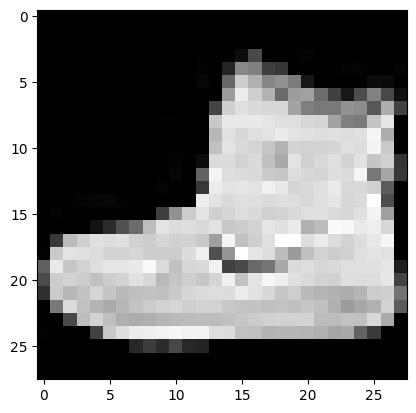

In [ ]:
cv_image = image.permute(1,2,0)
plt.imshow(cv_image, cmap='gray')

We can also check the train and test sets shape:

In [ ]:
print(f"Train data shape: {train_data.data.shape}")
print(f"Test data shape: {test_data.data.shape}")

print(f"Train labels shape: {train_data.targets.shape}")
print(f"Test labels shape: {test_data.targets.shape}")


Train data shape: torch.Size([60000, 28, 28])
Test data shape: torch.Size([10000, 28, 28])
Train labels shape: torch.Size([60000])
Test labels shape: torch.Size([10000])


In [ ]:
# print class names
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Prepare Dataloader

The DataLoader helps load data into a model for training and for inference.
It turns a large Dataset into a Python iterable of smaller chunks.
These smaller chunks are called batches or mini-batches and can be set by the batch_size parameter.

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7c07c3e33370>, <torch.utils.data.dataloader.DataLoader object at 0x7c07c3e332b0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


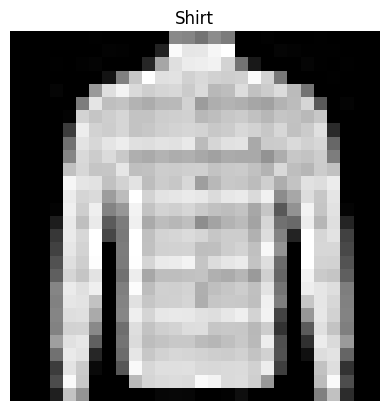

In [ ]:
# Show a sample
torch.manual_seed(1)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

# Classification with simple NN as in the last lecture

For a simple NN, the layers are linear layers with ReLU. The input, output and middle layer features are 1D vectors. To employ simple NN for image classification as in this example, we need to flatten the 2D image into a 1D array.

In [ ]:
# Create a flatten layer
flatten_layer = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_layer(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


Now let's create a simple NN model with 3 layers:

In [ ]:
from torch import nn
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten the input
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

torch.manual_seed(1)

# Need to setup model with input parameters
model_1 = FashionMNISTModelV1(input_shape=784, # one for every pixel (28x28)
    hidden_units=256, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_1.to(device)



FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
# Let's calculate the accuracy
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device) # send accuracy function to device

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9) # lr = learning rate

Now we can create training and testing loop:

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(1)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 10

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_1.train()
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model_1(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_1.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model_1(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += acc_fn(test_pred.argmax(dim=1), y)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.57974 | Test loss: 0.45898, Test acc: 0.83%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.39419 | Test loss: 0.42063, Test acc: 0.85%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.35545 | Test loss: 0.38684, Test acc: 0.86%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.32784 | Test loss: 0.35679, Test acc: 0.87%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looke

# Classification with a CNN model



In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(1)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=32,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.01, momentum=0.9)

We can functionize our training and testing loop:

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(1)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=acc_fn,
        device=device
    )


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.53148 | Train accuracy: 0.81%
Test loss: 0.34832 | Test accuracy: 0.87%

Epoch: 1
---------
Train loss: 0.31716 | Train accuracy: 0.89%
Test loss: 0.31597 | Test accuracy: 0.89%

Epoch: 2
---------
Train loss: 0.27309 | Train accuracy: 0.90%
Test loss: 0.29209 | Test accuracy: 0.90%

Epoch: 3
---------
Train loss: 0.24916 | Train accuracy: 0.91%
Test loss: 0.26370 | Test accuracy: 0.91%

Epoch: 4
---------
Train loss: 0.22942 | Train accuracy: 0.92%
Test loss: 0.28028 | Test accuracy: 0.90%

Epoch: 5
---------
Train loss: 0.21519 | Train accuracy: 0.92%
Test loss: 0.24806 | Test accuracy: 0.91%

Epoch: 6
---------
Train loss: 0.20296 | Train accuracy: 0.93%
Test loss: 0.25997 | Test accuracy: 0.91%

Epoch: 7
---------
Train loss: 0.19306 | Train accuracy: 0.93%
Test loss: 0.23684 | Test accuracy: 0.92%

Epoch: 8
---------
Train loss: 0.18349 | Train accuracy: 0.93%
Test loss: 0.25609 | Test accuracy: 0.91%

Epoch: 9
---------
Train loss: 0.17516 | Train

We can compare the number of parameters and computational complexity of these two models with ptflops:

In [ ]:
!pip install ptflops

In [ ]:
# compare number of parameters
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(model_1, (1, 28, 28), as_strings=True, backend='pytorch',
                                          print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('NN Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('NN Number of parameters: ', params))

macs, params = get_model_complexity_info(model_2, (1, 28, 28), as_strings=True, backend='pytorch',
                                          print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('CNN Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('CNN Number of parameters: ', params))

FashionMNISTModelV1(
  269.32 k, 100.000% Params, 269.83 KMac, 99.811% MACs, 
  (layer_stack): Sequential(
    269.32 k, 100.000% Params, 269.83 KMac, 99.811% MACs, 
    (0): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (1): Linear(200.96 k, 74.617% Params, 200.96 KMac, 74.334% MACs, in_features=784, out_features=256, bias=True)
    (2): ReLU(0, 0.000% Params, 256.0 Mac, 0.095% MACs, )
    (3): Linear(65.79 k, 24.429% Params, 65.79 KMac, 24.336% MACs, in_features=256, out_features=256, bias=True)
    (4): ReLU(0, 0.000% Params, 256.0 Mac, 0.095% MACs, )
    (5): Linear(2.57 k, 0.954% Params, 2.57 KMac, 0.951% MACs, in_features=256, out_features=10, bias=True)
  )
)
NN Computational complexity:    270.35 KMac
NN Number of parameters:        269.32 k
FashionMNISTModelV2(
  43.75 k, 100.000% Params, 11.24 MMac, 99.170% MACs, 
  (block_1): Sequential(
    9.57 k, 21.868% Params, 7.58 MMac, 66.870% MACs, 
    (0): Conv2d(320, 0.731% Params, 250.88 KMac, 2.214

#How to use off-the-shelf pretrained models to perform face recognition

The deep learning/AI community believe in open sourse code and models to accelerate the progress of this field. There are confereces such as CVPR, ICML, NeurIPS for the researchers to publish and share their findings. There are tons of pretrained state-of-the-art models on GitHub for people to build new interesting projects on top of them, or push the limits of the SOTA models. Here we try to build a face recognition project based on pretrained models.

In [ ]:
# we need facenet toolbox for this project https://github.com/timesler/facenet-pytorch
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5
  Attempting unins

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

workers = 4 #we try to allocate 4 workers

Running on device: cpu


We are going to use a popular face detection model MTCNN [(paper)](https://arxiv.org/abs/1604.02878) to locate faces in image first.

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

Then we will use a face recognition model trained on vggface2 [(Git)](https://github.com/ox-vgg/vgg_face2) with InceptionResnetV1 [link](https://www.researchgate.net/figure/Architecture-of-Inception-ResNet-V1-model-20_fig5_360822230) as backbone to recognize the face in the database.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Now we can load our dataset:

In [ ]:
# unzip test_images.zip

!unzip -q test_images.zip

replace test_images/angelina_jolie/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Now we can first perform face detection with MTCNN

In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999876
Face detected with probability: 0.999992


Calculate face embeddings with InceptionResnetV1:

In [ ]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

print(embeddings.shape)

torch.Size([5, 512])


Here we can see that the InceptionResnetV1 model outputs a vector of 512 numbers for each image as the embeddings. Here is a bit more explanation of face embeddings and why does it work [(link)](https://uysim.medium.com/face-embedding-and-what-you-need-to-know-a623c7111b5).

Now we can distinguish the faces from each other.

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  \
angelina_jolie        0.000000        1.447480     0.887728   1.434377   
bradley_cooper        1.447480        0.000000     1.313749   1.011981   
kate_siegel           0.887728        1.313749     0.000000   1.388993   
paul_rudd             1.434377        1.011981     1.388993   0.000000   
shea_whigham          1.399073        1.038684     1.379655   1.104095   

                shea_whigham  
angelina_jolie      1.399073  
bradley_cooper      1.038684  
kate_siegel         1.379655  
paul_rudd           1.104095  
shea_whigham        0.000000  


This embedding set can be used as a database to recognize new queries.


In [ ]:
query1 = cv2.imread('query1.jpg')
query2 = cv2.imread('query2.jpg')
# we need to convert the image to PIL.Image for mtcnn input
query1 = Image.fromarray(cv2.cvtColor(query1, cv2.COLOR_BGR2RGB))
query2 = Image.fromarray(cv2.cvtColor(query2, cv2.COLOR_BGR2RGB))

face_aligned1, prob1 = mtcnn(query1, return_prob=True)
face_aligned2, prob2 = mtcnn(query2, return_prob=True)

aligned = torch.stack([face_aligned1, face_aligned2]).to(device)
query_embeddings = resnet(aligned).detach().cpu()

Text(0.5, 1.0, 'angelina_jolie')

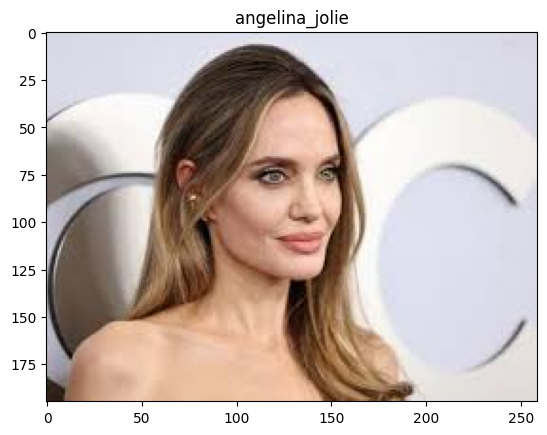

In [ ]:
# compute distances of query image and images in database
dists1 = [(e - query_embeddings[0]).norm().item() for e in embeddings]
# find the closest one
name = names[np.argmin(dists1)]

plt.imshow(query1); plt.title(name)

Text(0.5, 1.0, 'kate_siegel')

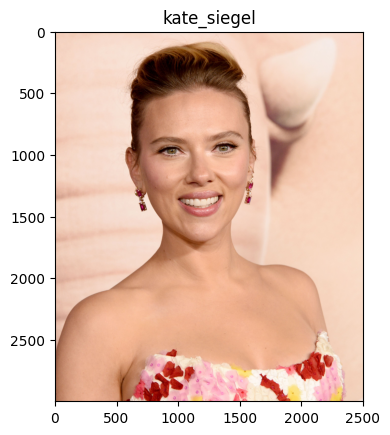

In [ ]:
dists2 = [(e - query_embeddings[1]).norm().item() for e in embeddings]
# find the closest one
name = names[np.argmin(dists2)]

plt.imshow(query2); plt.title(name)

In [ ]:
# here we can examine the dists2 to figure out why
print(dists2)

[1.4434881210327148, 1.400850772857666, 1.3901392221450806, 1.456017255783081, 1.467759132385254]


We can simply set a threshold of 1 to filter out failed samples like this.

1.3901392221450806


Text(0.5, 1.0, 'Unknown')

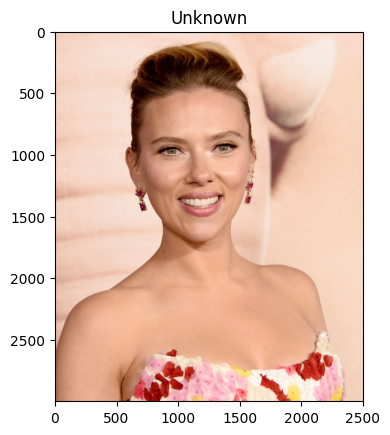

In [ ]:
dists2 = [(e - query_embeddings[1]).norm().item() for e in embeddings]
# find the closest one
id = np.argmin(dists2)
val = dists2[id]
print(val)
if val > 1:
    name = 'Unknown'
else:
    name = names[np.argmin(dists2)]

plt.imshow(query2); plt.title(name)

You can modify your database by add more entries. For example, you can add Scarlett Johansson to embeddings and names so that query2 can be recognized.

In [ ]:
scarlett_johansson = cv2.imread('Scarlett_Johansson.jpg')
# we need to convert the image to PIL.Image for mtcnn input
query_scarlett_johansson = Image.fromarray(cv2.cvtColor(scarlett_johansson, cv2.COLOR_BGR2RGB))

face_aligned, prob = mtcnn(query_scarlett_johansson, return_prob=True)
# we need to add 1 dimension to face_aligned since resnet() is expecting 4D input

face_aligned = torch.unsqueeze(face_aligned, 0).to(device)
new_embedding = resnet(face_aligned).detach().cpu()

In [ ]:
# we can now add the embedding and name to the database
embeddings = torch.cat([embeddings, new_embedding])
names = names + ['Scarlett Johansson']

0.5951061248779297


Text(0.5, 1.0, 'Scarlett Johansson')

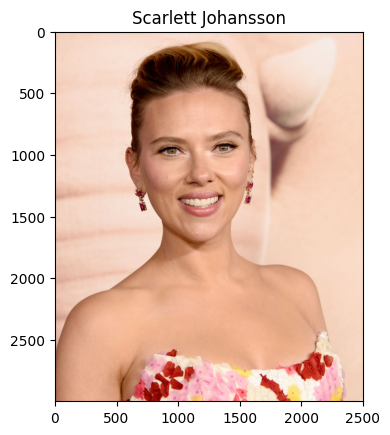

In [ ]:
# we can perform face recognition for query2 again
dists2 = [(e - query_embeddings[1]).norm().item() for e in embeddings]
# find the closest one
id = np.argmin(dists2)
val = dists2[id]
print(val)
if val > 1:
    name = 'Unknown'
else:
    name = names[np.argmin(dists2)]

plt.imshow(query2); plt.title(name)